# Глава 0. Общая идея использования KAN архитектуры для классификации 

In [1]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np
import os

D:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
D:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [92]:
dataset = {}
train_input, train_label = make_moons(n_samples=1000, shuffle=True, noise=0.30, random_state=42)
test_input, test_label = make_moons(n_samples=1000, shuffle=True, noise=0.40, random_state=42)

In [93]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

dtype = torch.get_default_dtype()

cuda:0


In [94]:
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

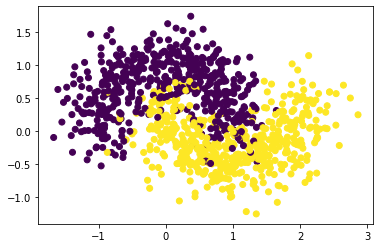

In [95]:
X = dataset['train_input']
y = dataset['train_label']
plt.scatter(X[:,0].cpu().detach().numpy(), X[:,1].cpu().detach().numpy(), c=y[:].cpu().detach().numpy())

In [96]:
model = KAN(width=[2,2], grid=3, k=3, seed=2024, device=device, auto_save=False)

def train_acc():
    correct = 0
    total = len(dataset["train_label"])
    
    outputs = model(dataset["train_input"])
    _, predicted = torch.max(outputs, 1)
    
    correct += (predicted == dataset["train_label"]).sum()
    accuracy = correct / total
    return accuracy
                            
def test_acc():
    correct = 0
    total = len(dataset["test_label"])
    
    outputs = model(dataset["test_input"])
    _, predicted = torch.max(outputs, 1)
    
    correct += (predicted == dataset["test_label"]).sum()
    accuracy = correct / total
    return accuracy

results = model.fit(dataset, 
                    opt="LBFGS", 
                    steps=200, 
                    metrics=(train_acc, test_acc), 
                    loss_fn=torch.nn.CrossEntropyLoss());

| train_loss: 4.50e-01 | test_loss: 6.28e-01 | reg: 2.52e+03 | : 100%|█| 200/200 [00:15<00:00, 13.18


In [101]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9895569682121277, c=2
fixing (0,0,1) with sin, r2=0.9896111488342285, c=2
fixing (0,1,0) with sin, r2=0.9950007200241089, c=2
fixing (0,1,1) with sin, r2=0.9960446953773499, c=2
saving model version 0.2


In [102]:
formula1, formula2 = model.symbolic_formula()[0]

In [103]:
formula1

-870.952209472656*sin(1.33439981937408*x_1 + 5.2129602432251) - 683.948791503906*sin(2.15063977241516*x_2 + 8.19767951965332) - 164.272689819336

In [104]:
formula2

-863.983703613281*sin(1.35103976726532*x_1 + 5.21192026138306) - 668.3779296875*sin(2.20023989677429*x_2 + 8.19816017150879) - 172.557174682617

saving model version 0.3


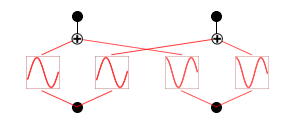

In [105]:
model = model.prune()
model.plot()

In [106]:
def validate_model(model, X, y, device):
    correct = 0
    total = len(y)
    
    outputs = model(X)
    _, predicted = torch.max(outputs, 1)
    
    correct += (predicted == y).sum()
    accuracy = correct / total
    return accuracy

In [107]:
train_accuracy = validate_model(model, dataset["train_input"], dataset["train_label"] , device)
test_accuracy = validate_model(model, dataset["test_input"], dataset["test_label"] , device)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.7830000519752502
Test Accuracy: 0.7520000338554382


# Глава 1. Использование KAN как самостоятельной сети 

## 1.1. Использование архитектуры KAN без предварительной обработки изображений

In [14]:
from kan import KAN
import torch
import numpy as np
import os
from torchvision import transforms
from PIL import Image

In [15]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), 
                         std=(0.26862954, 0.26130258, 0.27577711))
])

In [49]:
def shuffle_images(images, labels, filenames=None):
    indices = np.arange(len(labels))
    np.random.shuffle(indices)

    images = images[indices]
    labels = labels[indices]
    
    if filenames:
        filenames = filenames[indices]
    
    return images, labels, filenames

In [17]:
def make_dataset_for_kan(train_images, train_labels, test_images, test_labels):

    dataset = {}

    dataset['train_input'] = torch.from_numpy(train_images.cpu().numpy()).type(dtype).to(device)
    dataset['train_label'] = torch.from_numpy(train_labels).type(torch.long).to(device)

    dataset['test_input'] = torch.from_numpy(test_images.cpu().numpy()).type(dtype).to(device)
    dataset['test_label'] = torch.from_numpy(test_labels).type(torch.long).to(device)
    
    return dataset

In [18]:
import matplotlib.pyplot as plt

def plot_kan_results(results):

    train_loss = results['train_loss']
    test_loss = results['test_loss']

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_loss)), train_loss, label='Train Loss', marker='o', linestyle='-', color='blue')
    plt.plot(range(len(test_loss)), test_loss, label='Test Loss', marker='s', linestyle='--', color='red')

    plt.title('KAN Architecture. Train/Test Loss', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.show()

### 1.1.1. Smoking Dataset

In [19]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
train_path = './smokers_dataset/Training'
test_path = './smokers_dataset/Testing'
dtype = torch.get_default_dtype()

In [20]:
def process_images(image_dir:str, transforms=None):
    """
    Process smoking dataset from directory using transforms
    
    Args:
        image_dir (str): Путь к директории с исходными изображениями.

    Returns:
        - Список обработанных тензоров изображений.
        - Список меток для изображений.
        - Список с именами файлов
    """
    
    processed_images = []
    labels = []
    filenames = []
    
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(".jpg"):
            image_path = os.path.join(image_dir, filename)
            
            image = Image.open(image_path).convert("RGB")
            
            label = 0 if "notsmoking" in filename else 1 if "smoking" in filename else None
            if label is not None:
                labels.append(label)
                filenames.append(filename)
            else:
                print(f"Не удалось определить метку для файла: {filename}")
            
            processed_image = transform(image)
            processed_images.append(processed_image.view(-1))
            
#             print(f"processed: {filename}, value {processed_image}")
    
    return torch.stack(processed_images), np.array(labels), np.array(filenames)

In [21]:
train_images, train_labels, train_filenames = process_images(train_path, transform)
test_images, test_labels, test_filenames = process_images(test_path, transform)

In [22]:
print(f"Train Images Size: {train_images.shape}")
print(f"Test Images Size: {test_images.shape}")

Train Images Size: torch.Size([716, 37632])
Test Images Size: torch.Size([224, 37632])


In [23]:
indices = np.arange(len(train_labels))
np.random.shuffle(indices)

train_images = train_images[indices]
train_labels = train_labels[indices]
train_filenames = train_filenames[indices]

In [24]:
indices = np.arange(len(test_labels))
np.random.shuffle(indices)

test_images = test_images[indices]
test_labels = test_labels[indices]
test_filenames = test_filenames[indices]

In [25]:
answers = {filename : label for filename, label in zip(train_filenames, train_labels)}
answers

{'notsmoking_0089.jpg': 0,
 'notsmoking_0090.jpg': 0,
 'smoking_0035.jpg': 1,
 'notsmoking_0245.jpg': 0,
 'notsmoking_0011.jpg': 0,
 'notsmoking_0157.jpg': 0,
 'notsmoking_0436.jpg': 0,
 'notsmoking_0392.jpg': 0,
 'smoking_0327.jpg': 1,
 'notsmoking_0309.jpg': 0,
 'smoking_0146.jpg': 1,
 'smoking_0099.jpg': 1,
 'smoking_0267.jpg': 1,
 'smoking_0126.jpg': 1,
 'notsmoking_0458.jpg': 0,
 'notsmoking_0523.jpg': 0,
 'notsmoking_0230.jpg': 0,
 'notsmoking_0379.jpg': 0,
 'smoking_0357.jpg': 1,
 'smoking_0186.jpg': 1,
 'notsmoking_0093.jpg': 0,
 'smoking_0539.jpg': 1,
 'smoking_0028.jpg': 1,
 'smoking_0011.jpg': 1,
 'notsmoking_0240.jpg': 0,
 'notsmoking_0277.jpg': 0,
 'smoking_0444.jpg': 1,
 'notsmoking_0441.jpg': 0,
 'smoking_0097.jpg': 1,
 'notsmoking_0266.jpg': 0,
 'notsmoking_0033.jpg': 0,
 'notsmoking_0106.jpg': 0,
 'smoking_0363.jpg': 1,
 'notsmoking_0552.jpg': 0,
 'notsmoking_0342.jpg': 0,
 'smoking_0022.jpg': 1,
 'smoking_0207.jpg': 1,
 'smoking_0115.jpg': 1,
 'smoking_0462.jpg': 1,
 

In [26]:
dataset = {}

dataset['train_input'] = torch.from_numpy(train_images.cpu().numpy()).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_labels).type(torch.long).to(device)

dataset['test_input'] = torch.from_numpy(test_images.cpu().numpy()).type(dtype).to(device)
dataset['test_label'] = torch.from_numpy(test_labels).type(torch.long).to(device)

In [27]:
def train_acc():
    correct = 0
    total = len(dataset["train_label"])
    
    outputs = model(dataset["train_input"])
    _, predicted = torch.max(outputs, 1)
    
    correct += (predicted == dataset["train_label"]).sum()
    accuracy = correct / total
    
    return accuracy
                            
def test_acc():
    correct = 0
    total = len(dataset["test_label"])
    
    outputs = model(dataset["test_input"])
    _, predicted = torch.max(outputs, 1)
    
    correct += (predicted == dataset["test_label"]).sum()
    accuracy = correct / total
    return accuracy

In [28]:
%%time
model = KAN(width=[train_images.shape[1], 2], 
            grid=5, 
            k=3, 
            seed=42, 
            device=device, 
            auto_save=True, 
            ckpt_path='./KAN_model')

results = model.fit(dataset, 
                    opt="LBFGS", 
                    steps=50,  
                    loss_fn=torch.nn.CrossEntropyLoss(), 
                    lamb=0.02, batch=64, lr=1e-4)

checkpoint directory created: ./KAN_model
saving model version 0.0


| train_loss: 5.94e-01 | test_loss: 7.73e-01 | reg: 2.48e+01 | : 100%|█| 50/50 [01:02<00:00,  1.25s/


saving model version 0.1
Wall time: 1min 6s


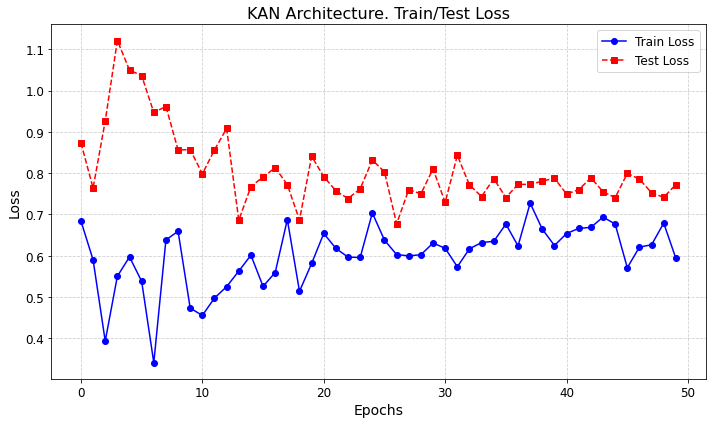

In [29]:
import matplotlib.pyplot as plt

train_loss = results['train_loss']
test_loss = results['test_loss']

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_loss)), train_loss, label='Train Loss', marker='o', linestyle='-', color='blue')
plt.plot(range(len(test_loss)), test_loss, label='Test Loss', marker='s', linestyle='--', color='red')

plt.title('KAN Architecture. Train/Test Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

In [30]:
def validate_kan_model(model, X, y):
    correct = 0
    total = len(y)
    
    outputs = model(X)
    _, predicted = torch.max(outputs, 1)
    
    correct += (predicted == y).sum()
    accuracy = correct / total
    return accuracy

In [40]:
%%time

train_accuracy = validate_kan_model(model, dataset["train_input"], dataset["train_label"])
test_accuracy = validate_kan_model(model, dataset["test_input"], dataset["test_label"])

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.7946926951408386
Test Accuracy: 0.723214328289032
Wall time: 529 ms


<timed exec>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1/15, Loss: 0.6568
Training complete.
Epoch 2/15, Loss: 0.5690
Training complete.
Epoch 3/15, Loss: 0.5368
Training complete.
Epoch 4/15, Loss: 0.5344
Training complete.
Epoch 5/15, Loss: 0.5171
Training complete.
Epoch 6/15, Loss: 0.5150
Training complete.
Epoch 7/15, Loss: 0.5238
Training complete.
Epoch 8/15, Loss: 0.4909
Training complete.
Epoch 9/15, Loss: 0.4978
Training complete.
Epoch 10/15, Loss: 0.5031
Training complete.
Epoch 11/15, Loss: 0.4958
Training complete.
Epoch 12/15, Loss: 0.4822
Training complete.
Epoch 13/15, Loss: 0.4591
Training complete.
Epoch 14/15, Loss: 0.4495
Training complete.
Epoch 15/15, Loss: 0.4658
Training complete.


<timed exec>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train Accuracy: 0.7946927374301676
Test Accuracy: 0.7232142857142857


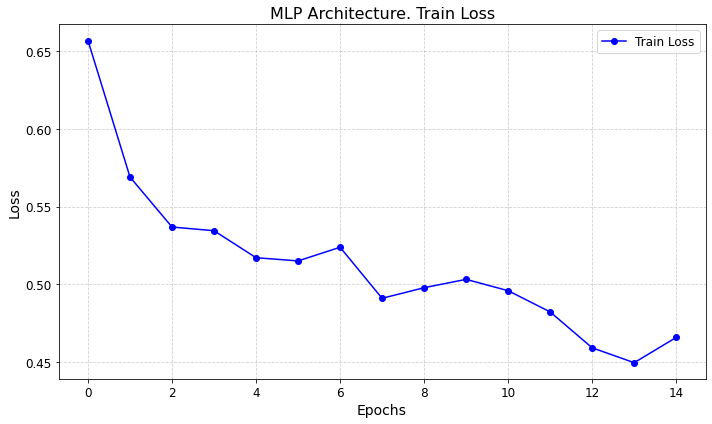

Wall time: 23 s


In [32]:
%%time
# Using MLP

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layers = []
        previous_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))
            layers.append(nn.ReLU())  # Функция активации
            previous_size = hidden_size
        layers.append(nn.Linear(previous_size, output_size))  # Выходной слой
        
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

input_size = train_images.shape[1]
hidden_sizes = [train_images.shape[1] // 4, train_images.shape[1] // 16]
output_size = 2
batch_size = 64
epochs = 15

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

smoking_dataset = TensorDataset(dataset["train_input"].to(device), 
                                torch.tensor(dataset["train_label"]).to(device, dtype=torch.long)
)

dataloader = DataLoader(smoking_dataset, batch_size=batch_size, shuffle=True)

model = NeuralNetwork(input_size, hidden_sizes, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-7)

train_mlp_loss = []

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")
    train_mlp_loss.append(total_loss / len(dataloader))
    
    print("Training complete.")


def validate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

test_dataset = TensorDataset(dataset["test_input"].to(device), 
                             torch.tensor(dataset["test_label"]).to(device, dtype=torch.long))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_accuracy = validate_model(model, dataloader, device)
test_accuracy = validate_model(model, test_dataloader, device)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_mlp_loss)), train_mlp_loss, label='Train Loss', marker='o', linestyle='-', color='blue')

plt.title('MLP Architecture. Train Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

Промежуточный вывод: получили одинаковое качество. Общее время работы для KAN архитектуры: ~120sec. Общее время для MLP: ~25sec

## 1.2. Использование архитектуры KAN c предварительной обработкой изображений

## 1.2.1 ResNet50 | Smoking Dataset 

D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


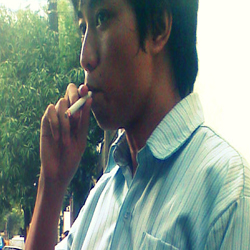

In [33]:
import torch
from torchvision import models, transforms
from PIL import Image

resnet = models.resnet50(pretrained=True)
model_embbed = torch.nn.Sequential(*(list(resnet.children())[:-1]))
model_embbed.eval()

image = Image.open("./images/smoking_0125.jpg").convert("RGB")
image

In [34]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),          
    transforms.Normalize(          
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
])

input_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    embedding = model_embbed(input_tensor).squeeze()

In [35]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
train_path = './smokers_dataset/Training'
test_path = './smokers_dataset/Testing'
dtype = torch.get_default_dtype()

In [36]:
def process_images(image_dir:str, model_embbed, transform=None):
    """
    Process smoking dataset from directory using transforms
    
    Args:
        image_dir (str): Путь к директории с исходными изображениями.

    Returns:
        - Список обработанных тензоров изображений.
        - Список меток для изображений.
        - Список с именами файлов
    """
    
    processed_images = []
    labels = []
    filenames = []
    
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(".jpg"):
            image_path = os.path.join(image_dir, filename)
            
            image = Image.open(image_path).convert("RGB")
            
            label = 0 if "notsmoking" in filename else 1 if "smoking" in filename else None
            if label is not None:
                labels.append(label)
                filenames.append(filename)
            else:
                print(f"Не удалось определить метку для файла: {filename}")
            
            processed_image = transform(image).unsqueeze(0)
            with torch.no_grad():
                embedding = model_embbed(processed_image).squeeze()
                processed_images.append(embedding)
            
#             print(f"processed: {filename}, value {processed_image}")
    
    return torch.stack(processed_images), np.array(labels), np.array(filenames)

In [58]:
train_images, train_labels, train_filenames = process_images(train_path, model_embbed, transform)
test_images, test_labels, test_filenames = process_images(test_path, model_embbed, transform)

In [59]:
print(f"Train Images Size: {train_images.shape}")
print(f"Test Images Size: {test_images.shape}")

Train Images Size: torch.Size([716, 2048])
Test Images Size: torch.Size([224, 2048])


In [60]:
train_images, train_labels, _ = shuffle_images(train_images, train_labels)
test_images, test_labels, _ = shuffle_images(test_images, test_labels)

dataset = make_dataset_for_kan(train_images, train_labels, test_images, test_labels)

In [61]:
%%time
model = KAN(width=[train_images.shape[1], 2], 
            grid=5, 
            k=3, 
            seed=42, 
            device=device, 
            auto_save=True, 
            ckpt_path='./KAN_model')

results = model.fit(dataset, 
                    opt="LBFGS", 
                    steps=50,  
                    loss_fn=torch.nn.CrossEntropyLoss(), 
                    lamb=0.02, batch=64, lr=1e-4)

checkpoint directory created: ./KAN_model
saving model version 0.0


| train_loss: 6.66e-01 | test_loss: 5.32e-01 | reg: 1.66e+01 | : 100%|█| 50/50 [00:10<00:00,  4.75it

saving model version 0.1
Wall time: 10.7 s


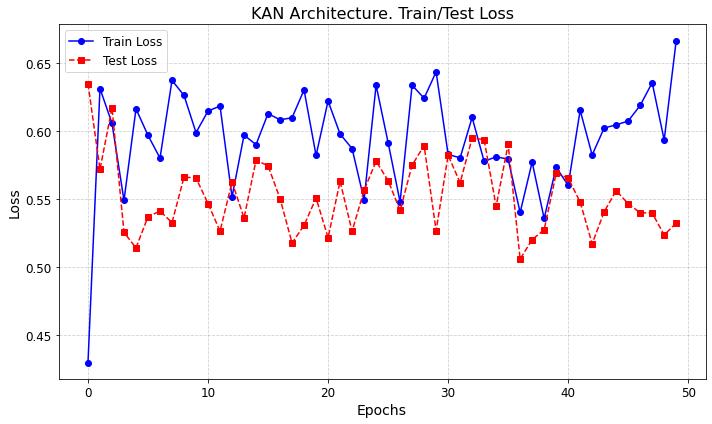

In [62]:
plot_kan_results(results)

In [63]:
%%time

train_accuracy = validate_kan_model(model, dataset["train_input"], dataset["train_label"])
test_accuracy = validate_kan_model(model, dataset["test_input"], dataset["test_label"])

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.8784915804862976
Test Accuracy: 0.9330357313156128
Wall time: 2.35 s


## 1.2.2 OpenAI CLIP | Smoking Dataset

In [64]:
import numpy as np
import torch
import os

import clip
from PIL import Image

In [65]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("./images/smoking_0125.jpg").convert("RGB")).unsqueeze(0).to(device)
image

tensor([[[[ 1.9157,  1.9157,  1.9303,  ...,  1.9303,  1.9303,  1.9303],
          [ 1.9303,  1.9303,  1.9157,  ...,  1.9303,  1.9303,  1.9303],
          [ 1.8865,  1.8281,  1.8573,  ...,  1.9303,  1.9303,  1.9303],
          ...,
          [-1.1353, -1.1499, -0.5806,  ...,  0.6311,  0.1931, -0.0259],
          [-1.3981, -0.8434,  0.4851,  ...,  0.5581,  0.0617, -0.0113],
          [-1.5149, -0.8726,  0.5435,  ...,  0.4851, -0.0405,  0.0179]],

         [[ 2.0749,  2.0599,  2.0599,  ...,  2.0749,  2.0749,  2.0749],
          [ 2.0599,  2.0749,  2.0749,  ...,  2.0749,  2.0749,  2.0749],
          [ 2.0599,  2.0149,  2.0449,  ...,  2.0749,  2.0749,  2.0749],
          ...,
          [ 0.6041,  0.3340, -0.2363,  ...,  0.9343,  0.7542,  0.7392],
          [-0.3264, -0.1913,  0.4691,  ...,  0.8442,  0.6191,  0.6792],
          [-1.2418, -0.7766,  0.4090,  ...,  0.8292,  0.5891,  0.7092]],

         [[ 2.0321,  2.0037,  2.0606,  ...,  2.0321,  2.0321,  2.0321],
          [ 2.0606,  2.0037,  

In [66]:
embed = clip_model.encode_image(image)
embed.shape

torch.Size([1, 512])

In [67]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
train_path = './smokers_dataset/Training'
test_path = './smokers_dataset/Testing'
dtype = torch.get_default_dtype()

In [68]:
def process_images(image_dir:str, clip_model, preprocess, device):
    """
    Process smoking dataset from directory using transforms
    
    Args:
        image_dir (str): Путь к директории с исходными изображениями.

    Returns:
        - Список обработанных тензоров изображений.
        - Список меток для изображений.
        - Список с именами файлов
    """
    
    processed_images = []
    labels = []
    filenames = []
    
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(".jpg"):
            image_path = os.path.join(image_dir, filename)
            
            image = Image.open(image_path).convert("RGB")
            image = preprocess(image).unsqueeze(0).to(device)
            
            label = 0 if "notsmoking" in filename else 1 if "smoking" in filename else None
            if label is not None:
                labels.append(label)
                filenames.append(filename)
            else:
                print(f"Не удалось определить метку для файла: {filename}")
            
            with torch.no_grad():
                embedding = clip_model.encode_image(image).float().view(-1)
                processed_images.append(embedding)
            
#             print(f"processed: {filename}, value {processed_image}")
    
    return torch.stack(processed_images), np.array(labels), np.array(filenames)

In [69]:
train_images, train_labels, train_filenames = process_images(train_path, 
                                                             clip_model, 
                                                             preprocess, 
                                                             device)

test_images, test_labels, test_filenames = process_images(test_path, 
                                                          clip_model, 
                                                          preprocess, 
                                                          device)

In [70]:
print(f"Train Images Size: {train_images.shape}")
print(f"Test Images Size: {test_images.shape}")

Train Images Size: torch.Size([716, 512])
Test Images Size: torch.Size([224, 512])


In [72]:
train_images, train_labels, _ = shuffle_images(train_images, train_labels)
test_images, test_labels, _ = shuffle_images(test_images, test_labels)

dataset = make_dataset_for_kan(train_images, train_labels, test_images, test_labels)

In [73]:
%%time
model = KAN(width=[train_images.shape[1], 2], 
            grid=5, 
            k=3, 
            seed=42, 
            device=device, 
            auto_save=True, 
            ckpt_path='./KAN_model')

results = model.fit(dataset, 
                    opt="LBFGS", 
                    steps=50,  
                    loss_fn=torch.nn.CrossEntropyLoss(), 
                    lamb=0.02, batch=64, lr=1e-4)

checkpoint directory created: ./KAN_model
saving model version 0.0


| train_loss: 5.19e-01 | test_loss: 4.89e-01 | reg: 1.56e+01 | : 100%|█| 50/50 [00:08<00:00,  5.71it

saving model version 0.1
Wall time: 8.86 s


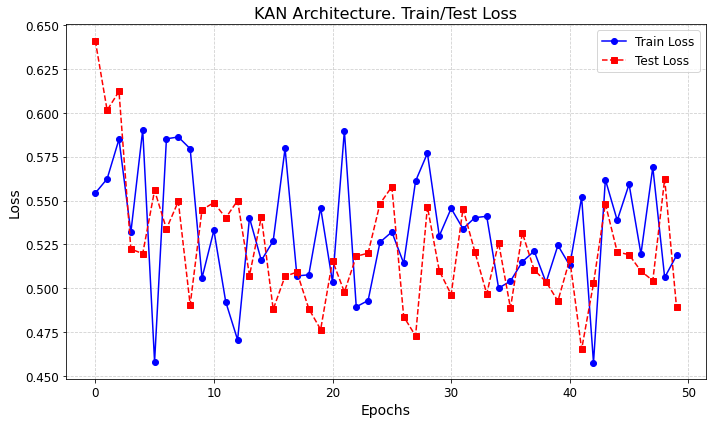

In [74]:
plot_kan_results(results)

In [75]:
%%time

train_accuracy = validate_kan_model(model, dataset["train_input"], dataset["train_label"])
test_accuracy = validate_kan_model(model, dataset["test_input"], dataset["test_label"])

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.931564211845398
Test Accuracy: 0.9375000596046448
Wall time: 546 ms


## 1.2.3 OpenAI CLIP | Satelite Dataset

In [108]:
import os
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import clip

In [109]:
data_path = './satellite_dataset/data'
classes = ['cloudy', 'desert', 'green_area', 'water']

In [110]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [111]:
def load_images(data_path, classes, clip_model, preprocess, device):
    processed_images = []
    labels = []
    filenames = []
    
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_path, class_name)
        
        if not os.path.exists(class_dir):
            print(f"Directory '{class_name}' not found.")
            continue
        
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            
            try: 
                image = Image.open(file_path).convert("RGB")
                image = preprocess(image).unsqueeze(0).to(device)
                
                labels.append(label)
                filenames.append(file_name)
                
                with torch.no_grad():
                    embedding = clip_model.encode_image(image).float().view(-1)
                    processed_images.append(embedding)
                    
            except:
                print(f"Error processing file {file_name}: {e}")
                
    return torch.stack(processed_images), np.array(labels), np.array(filenames)

In [112]:
satelite_images, satelite_labels, satelite_filenames = load_images(data_path, 
                                                                   classes,
                                                                   clip_model, 
                                                                   preprocess, 
                                                                   device)

In [113]:
print(f"Satelite Images size: {satelite_images.shape}")

Satelite Images size: torch.Size([5631, 512])


In [114]:
def split_data(images_tensor, labels_tensor, file_names, test_size=0.2, random_state=42):
    """
    Разделение данных на train и test с сохранением баланса классов.
    """
    class_indices = {}
    for idx, label in enumerate(labels_tensor):
        label = label.item()
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(idx)
    
    train_indices = []
    test_indices = []
    for label, indices in class_indices.items():
        torch.manual_seed(random_state)
        indices = torch.tensor(indices)
        num_test = int(len(indices) * test_size)
        shuffled_indices = indices[torch.randperm(len(indices))]
        test_indices.extend(shuffled_indices[:num_test].tolist())
        train_indices.extend(shuffled_indices[num_test:].tolist())
    
    train_images_tensor = images_tensor[train_indices]
    test_images_tensor = images_tensor[test_indices]
    train_labels_tensor = labels_tensor[train_indices]
    test_labels_tensor = labels_tensor[test_indices]
    train_files = [file_names[i] for i in train_indices]
    test_files = [file_names[i] for i in test_indices]
    
    return (train_images_tensor, train_labels_tensor, train_files), (test_images_tensor, test_labels_tensor, test_files)

In [115]:
train_data, test_data = split_data(satelite_images, 
                                   satelite_labels,
                                   satelite_filenames)

In [116]:
train_labels = train_data[1]

unique_values, counts = np.unique(train_labels, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value {value} occurs {count} times.")

Value 0 occurs 1200 times.
Value 1 occurs 905 times.
Value 2 occurs 1200 times.
Value 3 occurs 1200 times.


In [117]:
test_labels = test_data[1]

unique_values, counts = np.unique(test_labels, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Value {value} occurs {count} times.")

Value 0 occurs 300 times.
Value 1 occurs 226 times.
Value 2 occurs 300 times.
Value 3 occurs 300 times.


In [118]:
train_data[2]

['train_21657.jpg',
 'train_3036.jpg',
 'train_4603.jpg',
 'train_5180.jpg',
 'train_11486.jpg',
 'train_6987.jpg',
 'train_39385.jpg',
 'train_20675.jpg',
 'train_39500.jpg',
 'train_11150.jpg',
 'train_437.jpg',
 'train_11301.jpg',
 'train_12713.jpg',
 'train_3585.jpg',
 'train_5680.jpg',
 'train_23076.jpg',
 'train_36004.jpg',
 'train_21884.jpg',
 'train_16989.jpg',
 'train_18134.jpg',
 'train_18281.jpg',
 'train_29412.jpg',
 'train_8064.jpg',
 'train_4205.jpg',
 'train_30155.jpg',
 'train_31251.jpg',
 'train_36687.jpg',
 'train_36137.jpg',
 'train_21872.jpg',
 'train_20821.jpg',
 'train_20008.jpg',
 'train_2058.jpg',
 'train_476.jpg',
 'train_6573.jpg',
 'train_7820.jpg',
 'train_2396.jpg',
 'train_12353.jpg',
 'train_21098.jpg',
 'train_4116.jpg',
 'train_15974.jpg',
 'train_27302.jpg',
 'train_5220.jpg',
 'train_30056.jpg',
 'train_38446.jpg',
 'train_9108.jpg',
 'train_34079.jpg',
 'train_8809.jpg',
 'train_33597.jpg',
 'train_31530.jpg',
 'train_37495.jpg',
 'train_38610.jpg',


In [119]:
train_images, train_labels, _ = shuffle_images(train_data[0], train_data[1])
test_images, test_labels, _ = shuffle_images(test_data[0], test_data[1])

dataset = make_dataset_for_kan(train_images, train_labels, test_images, test_labels)

In [120]:
%%time
model = KAN(width=[train_images.shape[1], 4], 
            grid=5, 
            k=3, 
            seed=42, 
            device=device, 
            auto_save=True, 
            ckpt_path='./KAN_model')

results = model.fit(dataset, 
                    opt="LBFGS", 
                    steps=80,  
                    loss_fn=torch.nn.CrossEntropyLoss(), 
                    lamb=0.02, batch=64, lr=1e-4)

checkpoint directory created: ./KAN_model
saving model version 0.0


| train_loss: 5.86e-01 | test_loss: 5.71e-01 | reg: 2.47e+01 | : 100%|█| 80/80 [00:13<00:00,  5.96it

saving model version 0.1
Wall time: 13.6 s


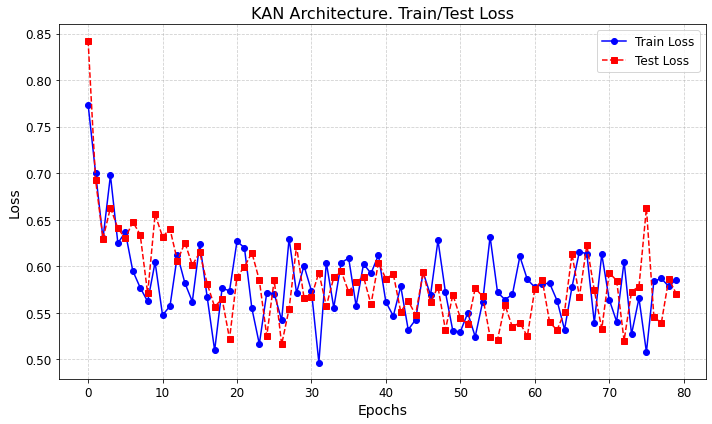

In [121]:
plot_kan_results(results)

In [122]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x, r2=0.003943934105336666, c=1
fixing (0,0,1) with x, r2=0.05561552196741104, c=1
fixing (0,0,2) with x, r2=1.685854294919409e-05, c=1
fixing (0,0,3) with x, r2=0.30906936526298523, c=1
fixing (0,1,0) with x, r2=0.2763559818267822, c=1
fixing (0,1,1) with x, r2=0.0013252735370770097, c=1
fixing (0,1,2) with x, r2=1.5200327652564738e-05, c=1
fixing (0,1,3) with x, r2=5.6912631407612935e-06, c=1
fixing (0,2,0) with x, r2=0.004295118153095245, c=1
fixing (0,2,1) with x, r2=0.32432103157043457, c=1
fixing (0,2,2) with x, r2=9.114971180679277e-05, c=1
fixing (0,2,3) with x, r2=0.007036906201392412, c=1
fixing (0,3,0) with x, r2=0.0008389817667193711, c=1
fixing (0,3,1) with x, r2=0.0004404218343552202, c=1
fixing (0,3,2) with x, r2=0.000673433009069413, c=1
fixing (0,3,3) with x, r2=1.3471220881910995e-05, c=1
fixing (0,4,0) with x, r2=0.00040751241613179445, c=1
fixing (0,4,1) with x, r2=0.0034102504141628742, c=1
fixing (0,4,2) with x, r2=0.039281003177165985, c=1
fix

fixing (0,39,2) with x^2, r2=0.9987476468086243, c=2
fixing (0,39,3) with x, r2=0.11420521140098572, c=1
fixing (0,40,0) with x, r2=0.0004869064432568848, c=1
fixing (0,40,1) with x, r2=0.0009827782632783055, c=1
fixing (0,40,2) with x, r2=0.003291719127446413, c=1
fixing (0,40,3) with x, r2=0.005520172417163849, c=1
fixing (0,41,0) with x, r2=5.82839384151157e-05, c=1
fixing (0,41,1) with x, r2=3.0691746360389516e-05, c=1
fixing (0,41,2) with x, r2=0.039728276431560516, c=1
fixing (0,41,3) with x, r2=0.10318070650100708, c=1
fixing (0,42,0) with x, r2=0.5995447635650635, c=1
fixing (0,42,1) with exp, r2=0.9894391894340515, c=2
fixing (0,42,2) with x, r2=0.9274705648422241, c=1
fixing (0,42,3) with sin, r2=0.9654439687728882, c=2
fixing (0,43,0) with x, r2=0.044253695756196976, c=1
fixing (0,43,1) with x, r2=0.015043945051729679, c=1
fixing (0,43,2) with x, r2=0.21626955270767212, c=1
fixing (0,43,3) with x, r2=0.05490494146943092, c=1
fixing (0,44,0) with x, r2=9.983069321606308e-05, 

fixing (0,79,0) with x, r2=0.044931549578905106, c=1
fixing (0,79,1) with x, r2=0.4124978184700012, c=1
fixing (0,79,2) with x, r2=0.009888218715786934, c=1
fixing (0,79,3) with exp, r2=0.9896525740623474, c=2
fixing (0,80,0) with x, r2=0.002129052532836795, c=1
fixing (0,80,1) with x, r2=0.0022371779195964336, c=1
fixing (0,80,2) with x, r2=0.0011212262324988842, c=1
fixing (0,80,3) with x, r2=0.00019374873954802752, c=1
fixing (0,81,0) with x, r2=0.0027580722235143185, c=1
fixing (0,81,1) with x, r2=0.0023693039547652006, c=1
fixing (0,81,2) with x, r2=0.008124873042106628, c=1
fixing (0,81,3) with x, r2=0.00259567447938025, c=1
fixing (0,82,0) with x, r2=0.0007026686216704547, c=1
fixing (0,82,1) with x, r2=0.00022373683168552816, c=1
fixing (0,82,2) with x, r2=0.16266360878944397, c=1
fixing (0,82,3) with x, r2=2.7432319257059135e-05, c=1
fixing (0,83,0) with x, r2=0.03600117191672325, c=1
fixing (0,83,1) with x, r2=0.014316818676888943, c=1
fixing (0,83,2) with exp, r2=0.968833982

fixing (0,118,1) with exp, r2=0.9999839067459106, c=2
fixing (0,118,2) with x, r2=7.957894467836013e-07, c=1
fixing (0,118,3) with x, r2=0.0002137463743565604, c=1
fixing (0,119,0) with exp, r2=0.9994161128997803, c=2
fixing (0,119,1) with x, r2=2.9572980565717444e-05, c=1
fixing (0,119,2) with x, r2=0.031734246760606766, c=1
fixing (0,119,3) with x, r2=0.0033317687921226025, c=1
fixing (0,120,0) with exp, r2=0.961732804775238, c=2
fixing (0,120,1) with x, r2=0.00025217412621714175, c=1
fixing (0,120,2) with x, r2=0.9354515075683594, c=1
fixing (0,120,3) with x, r2=0.9910633563995361, c=1
fixing (0,121,0) with x, r2=0.07594818621873856, c=1
fixing (0,121,1) with x, r2=0.14056681096553802, c=1
fixing (0,121,2) with x, r2=0.04291841387748718, c=1
fixing (0,121,3) with x, r2=0.20698536932468414, c=1
fixing (0,122,0) with exp, r2=0.9419193863868713, c=2
fixing (0,122,1) with x, r2=0.010167699307203293, c=1
fixing (0,122,2) with x, r2=0.014484942890703678, c=1
fixing (0,122,3) with x, r2=0.

fixing (0,156,1) with x, r2=0.0007364187040366232, c=1
fixing (0,156,2) with x, r2=0.0005878623342141509, c=1
fixing (0,156,3) with x, r2=7.011462730588391e-05, c=1
fixing (0,157,0) with exp, r2=0.9583385586738586, c=2
fixing (0,157,1) with x, r2=0.000999503768980503, c=1
fixing (0,157,2) with x, r2=0.004187908489257097, c=1
fixing (0,157,3) with x, r2=0.01679251715540886, c=1
fixing (0,158,0) with x, r2=0.23053580522537231, c=1
fixing (0,158,1) with exp, r2=0.9696256518363953, c=2
fixing (0,158,2) with x, r2=0.11038418859243393, c=1
fixing (0,158,3) with x, r2=0.01999109610915184, c=1
fixing (0,159,0) with x, r2=0.010776960290968418, c=1
fixing (0,159,1) with x, r2=0.029395336285233498, c=1
fixing (0,159,2) with exp, r2=0.9989232420921326, c=2
fixing (0,159,3) with x, r2=0.007281491532921791, c=1
fixing (0,160,0) with x, r2=0.004278742708265781, c=1
fixing (0,160,1) with x, r2=0.0006696560885757208, c=1
fixing (0,160,2) with x, r2=0.001372874598018825, c=1
fixing (0,160,3) with x, r2=

fixing (0,195,0) with exp, r2=0.9614508152008057, c=2
fixing (0,195,1) with x, r2=5.263089406071231e-06, c=1
fixing (0,195,2) with x, r2=5.045997681918379e-07, c=1
fixing (0,195,3) with x, r2=0.001886674901470542, c=1
fixing (0,196,0) with x, r2=0.013379152864217758, c=1
fixing (0,196,1) with x, r2=0.027331534773111343, c=1
fixing (0,196,2) with x, r2=0.0002467027516104281, c=1
fixing (0,196,3) with x, r2=0.0002618191356305033, c=1
fixing (0,197,0) with x, r2=0.0051466114819049835, c=1
fixing (0,197,1) with x, r2=0.026573244482278824, c=1
fixing (0,197,2) with x, r2=0.040268465876579285, c=1
fixing (0,197,3) with x, r2=0.018647372722625732, c=1
fixing (0,198,0) with x, r2=0.5617535710334778, c=1
fixing (0,198,1) with x, r2=0.6367238759994507, c=1
fixing (0,198,2) with x, r2=0.00428748456761241, c=1
fixing (0,198,3) with x, r2=0.12572842836380005, c=1
fixing (0,199,0) with x, r2=0.01074774656444788, c=1
fixing (0,199,1) with x, r2=0.001662177499383688, c=1
fixing (0,199,2) with x, r2=0.

fixing (0,233,1) with sin, r2=0.9998173117637634, c=2
fixing (0,233,2) with x, r2=0.1585073471069336, c=1
fixing (0,233,3) with x, r2=0.2604406774044037, c=1
fixing (0,234,0) with x, r2=0.09089529514312744, c=1
fixing (0,234,1) with exp, r2=0.9976110458374023, c=2
fixing (0,234,2) with exp, r2=0.9948687553405762, c=2
fixing (0,234,3) with exp, r2=0.9474928975105286, c=2
fixing (0,235,0) with x, r2=0.043493181467056274, c=1
fixing (0,235,1) with exp, r2=0.9941796660423279, c=2
fixing (0,235,2) with x, r2=0.11226864159107208, c=1
fixing (0,235,3) with x, r2=0.0023049921728670597, c=1
fixing (0,236,0) with x, r2=0.01902604103088379, c=1
fixing (0,236,1) with exp, r2=0.9557179808616638, c=2
fixing (0,236,2) with x, r2=0.0003091780818067491, c=1
fixing (0,236,3) with x, r2=0.002100408775731921, c=1
fixing (0,237,0) with x, r2=0.00024336285423487425, c=1
fixing (0,237,1) with x, r2=0.0017757142195478082, c=1
fixing (0,237,2) with x, r2=0.1795593649148941, c=1
fixing (0,237,3) with x, r2=0.00

fixing (0,271,1) with x, r2=0.0026030265726149082, c=1
fixing (0,271,2) with x, r2=0.004434246104210615, c=1
fixing (0,271,3) with x, r2=0.0016335210530087352, c=1
fixing (0,272,0) with exp, r2=0.9706053733825684, c=2
fixing (0,272,1) with exp, r2=0.9858556985855103, c=2
fixing (0,272,2) with x, r2=4.578013204081799e-07, c=1
fixing (0,272,3) with exp, r2=0.9851544499397278, c=2
fixing (0,273,0) with x, r2=0.18406742811203003, c=1
fixing (0,273,1) with x, r2=0.017829125747084618, c=1
fixing (0,273,2) with x, r2=0.005737547762691975, c=1
fixing (0,273,3) with x, r2=0.0030700257048010826, c=1
fixing (0,274,0) with x, r2=0.0035376213490962982, c=1
fixing (0,274,1) with x, r2=0.9380732178688049, c=1
fixing (0,274,2) with x, r2=0.00027255239547230303, c=1
fixing (0,274,3) with x, r2=0.0016510934801772237, c=1
fixing (0,275,0) with x, r2=0.36429277062416077, c=1
fixing (0,275,1) with x, r2=0.0034221725072711706, c=1
fixing (0,275,2) with exp, r2=0.9888502359390259, c=2
fixing (0,275,3) with x

fixing (0,309,1) with x, r2=0.01101460587233305, c=1
fixing (0,309,2) with x, r2=0.04877392202615738, c=1
fixing (0,309,3) with x, r2=0.003235473530367017, c=1
fixing (0,310,0) with x, r2=5.380662059906172e-06, c=1
fixing (0,310,1) with x, r2=0.0013644382124766707, c=1
fixing (0,310,2) with x, r2=1.6735551980673335e-05, c=1
fixing (0,310,3) with x, r2=0.0916329175233841, c=1
fixing (0,311,0) with x, r2=0.02194845862686634, c=1
fixing (0,311,1) with x, r2=0.0012004891177639365, c=1
fixing (0,311,2) with x, r2=0.0012106540380045772, c=1
fixing (0,311,3) with x, r2=0.0047278208658099174, c=1
fixing (0,312,0) with x, r2=0.0023879464715719223, c=1
fixing (0,312,1) with x, r2=0.38255080580711365, c=1
fixing (0,312,2) with x, r2=0.5609579086303711, c=1
fixing (0,312,3) with x, r2=0.0629706159234047, c=1
fixing (0,313,0) with x, r2=0.0010045968228951097, c=1
fixing (0,313,1) with x, r2=0.04560595750808716, c=1
fixing (0,313,2) with x, r2=0.02763008512556553, c=1
fixing (0,313,3) with exp, r2=0

fixing (0,347,3) with x, r2=0.028615182265639305, c=1
fixing (0,348,0) with x, r2=0.03878549113869667, c=1
fixing (0,348,1) with exp, r2=0.9632200598716736, c=2
fixing (0,348,2) with x, r2=0.00010588912846287712, c=1
fixing (0,348,3) with exp, r2=0.9858541488647461, c=2
fixing (0,349,0) with x^2, r2=0.9999822378158569, c=2
fixing (0,349,1) with x, r2=0.030665170401334763, c=1
fixing (0,349,2) with x^2, r2=0.9999913573265076, c=2
fixing (0,349,3) with x, r2=0.3739757835865021, c=1
fixing (0,350,0) with x, r2=0.14246706664562225, c=1
fixing (0,350,1) with x, r2=0.1020001769065857, c=1
fixing (0,350,2) with x, r2=0.0006766955484636128, c=1
fixing (0,350,3) with exp, r2=0.9818986654281616, c=2
fixing (0,351,0) with x, r2=0.003422322915866971, c=1
fixing (0,351,1) with x, r2=0.008243932388722897, c=1
fixing (0,351,2) with x, r2=0.3402940034866333, c=1
fixing (0,351,3) with x, r2=0.007777071557939053, c=1
fixing (0,352,0) with x, r2=0.026325294747948647, c=1
fixing (0,352,1) with x, r2=0.002

fixing (0,386,0) with x, r2=0.00019909083493985236, c=1
fixing (0,386,1) with x, r2=0.0001310539955738932, c=1
fixing (0,386,2) with x, r2=0.03858262300491333, c=1
fixing (0,386,3) with x, r2=0.0012233515735715628, c=1
fixing (0,387,0) with x, r2=0.00013099501666147262, c=1
fixing (0,387,1) with exp, r2=0.9999910593032837, c=2
fixing (0,387,2) with x, r2=0.0003644395910669118, c=1
fixing (0,387,3) with x, r2=0.000625004933681339, c=1
fixing (0,388,0) with x, r2=0.0012539578601717949, c=1
fixing (0,388,1) with x, r2=0.0001451261923648417, c=1
fixing (0,388,2) with x, r2=0.0023304647766053677, c=1
fixing (0,388,3) with x, r2=0.004088598303496838, c=1
fixing (0,389,0) with sin, r2=0.9903234839439392, c=2
fixing (0,389,1) with x^2, r2=0.9998331665992737, c=2
fixing (0,389,2) with x^2, r2=0.9998192191123962, c=2
fixing (0,389,3) with x^2, r2=0.9997290968894958, c=2
fixing (0,390,0) with exp, r2=0.9928433895111084, c=2
fixing (0,390,1) with x, r2=0.04818258062005043, c=1
fixing (0,390,2) wit

fixing (0,424,3) with x, r2=0.11158940196037292, c=1
fixing (0,425,0) with x, r2=0.015939954668283463, c=1
fixing (0,425,1) with x, r2=0.02369033172726631, c=1
fixing (0,425,2) with exp, r2=0.9635640382766724, c=2
fixing (0,425,3) with x, r2=0.0015924384351819754, c=1
fixing (0,426,0) with x, r2=0.0054183341562747955, c=1
fixing (0,426,1) with x, r2=0.020339686423540115, c=1
fixing (0,426,2) with x, r2=0.009362784214317799, c=1
fixing (0,426,3) with x, r2=0.001329978695139289, c=1
fixing (0,427,0) with x, r2=0.0017403587698936462, c=1
fixing (0,427,1) with x, r2=0.008227136917412281, c=1
fixing (0,427,2) with x, r2=0.001390866469591856, c=1
fixing (0,427,3) with x, r2=0.0006283213151618838, c=1
fixing (0,428,0) with x, r2=0.249912291765213, c=1
fixing (0,428,1) with x, r2=0.4969201385974884, c=1
fixing (0,428,2) with x, r2=0.012522152625024319, c=1
fixing (0,428,3) with x, r2=0.12920072674751282, c=1
fixing (0,429,0) with x, r2=0.04557234048843384, c=1
fixing (0,429,1) with x, r2=0.000

fixing (0,462,2) with x, r2=0.008801598101854324, c=1
fixing (0,462,3) with x, r2=0.09011001139879227, c=1
fixing (0,463,0) with x, r2=3.3861558677017456e-06, c=1
fixing (0,463,1) with x, r2=0.006611598189920187, c=1
fixing (0,463,2) with x, r2=0.0015155780129134655, c=1
fixing (0,463,3) with x, r2=0.05023278295993805, c=1
fixing (0,464,0) with x, r2=5.624798723147251e-05, c=1
fixing (0,464,1) with x, r2=0.08041715621948242, c=1
fixing (0,464,2) with x, r2=0.002259355504065752, c=1
fixing (0,464,3) with x, r2=0.021041208878159523, c=1
fixing (0,465,0) with x, r2=0.0021185814402997494, c=1
fixing (0,465,1) with x, r2=0.26838886737823486, c=1
fixing (0,465,2) with x, r2=0.0064520263113081455, c=1
fixing (0,465,3) with x, r2=0.15408433973789215, c=1
fixing (0,466,0) with x, r2=0.006862600799649954, c=1
fixing (0,466,1) with x, r2=0.9967566728591919, c=1
fixing (0,466,2) with x, r2=0.10124087333679199, c=1
fixing (0,466,3) with x^2, r2=0.9999847412109375, c=2
fixing (0,467,0) with x, r2=0.

fixing (0,500,3) with exp, r2=0.9718328714370728, c=2
fixing (0,501,0) with x, r2=0.0032052795868366957, c=1
fixing (0,501,1) with x, r2=0.8093779683113098, c=1
fixing (0,501,2) with x, r2=0.0016892921412363648, c=1
fixing (0,501,3) with x, r2=4.872934005106799e-05, c=1
fixing (0,502,0) with x, r2=0.014110390096902847, c=1
fixing (0,502,1) with x, r2=8.75792175065726e-05, c=1
fixing (0,502,2) with x, r2=0.005934290587902069, c=1
fixing (0,502,3) with x, r2=0.0036437909584492445, c=1
fixing (0,503,0) with x, r2=0.00033096710103563964, c=1
fixing (0,503,1) with x, r2=0.0009177371393889189, c=1
fixing (0,503,2) with x, r2=0.0003884035104420036, c=1
fixing (0,503,3) with exp, r2=0.9829680323600769, c=2
fixing (0,504,0) with sin, r2=0.9999334216117859, c=2
fixing (0,504,1) with x, r2=0.9903879165649414, c=1
fixing (0,504,2) with x^2, r2=0.9675898551940918, c=2
fixing (0,504,3) with x, r2=0.8651061654090881, c=1
fixing (0,505,0) with x, r2=0.01724964752793312, c=1
fixing (0,505,1) with x, r2

In [123]:
%%time

train_accuracy = validate_kan_model(model, dataset["train_input"], dataset["train_label"])
test_accuracy = validate_kan_model(model, dataset["test_input"], dataset["test_label"])

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.9498335123062134
Test Accuracy: 0.9493783712387085
Wall time: 1.5 s


saving model version 0.3


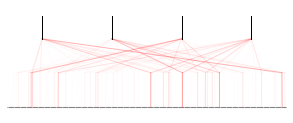

In [124]:
model = model.prune()
model.plot()

<timed exec>:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1/30, Loss: 1.2792
Training complete.
Epoch 2/30, Loss: 1.1083
Training complete.
Epoch 3/30, Loss: 0.9295
Training complete.
Epoch 4/30, Loss: 0.7663
Training complete.
Epoch 5/30, Loss: 0.6304
Training complete.
Epoch 6/30, Loss: 0.5246
Training complete.
Epoch 7/30, Loss: 0.4431
Training complete.
Epoch 8/30, Loss: 0.3771
Training complete.
Epoch 9/30, Loss: 0.3270
Training complete.
Epoch 10/30, Loss: 0.2865
Training complete.
Epoch 11/30, Loss: 0.2532
Training complete.
Epoch 12/30, Loss: 0.2259
Training complete.
Epoch 13/30, Loss: 0.2030
Training complete.
Epoch 14/30, Loss: 0.1839
Training complete.
Epoch 15/30, Loss: 0.1662
Training complete.
Epoch 16/30, Loss: 0.1516
Training complete.
Epoch 17/30, Loss: 0.1390
Training complete.
Epoch 18/30, Loss: 0.1285
Training complete.
Epoch 19/30, Loss: 0.1183
Training complete.
Epoch 20/30, Loss: 0.1094
Training complete.
Epoch 21/30, Loss: 0.1019
Training complete.
Epoch 22/30, Loss: 0.0947
Training complete.
Epoch 23/30, Loss: 

<timed exec>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


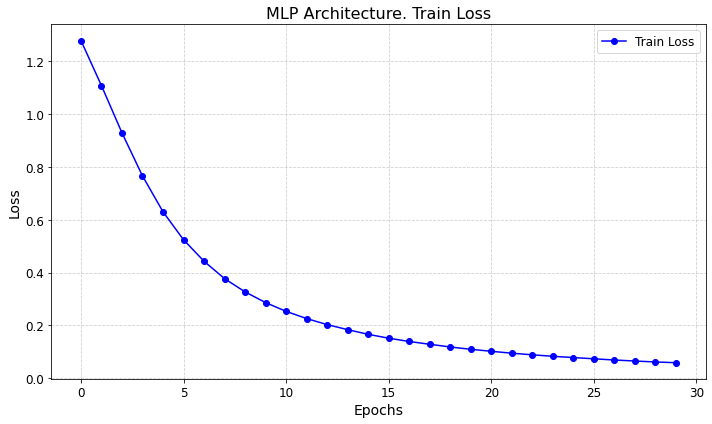

Wall time: 4.18 s


In [129]:
%%time
# Using MLP

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layers = []
        previous_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(previous_size, hidden_size))
            layers.append(nn.ReLU()) 
            previous_size = hidden_size
        layers.append(nn.Linear(previous_size, output_size))
        
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

input_size = train_images.shape[1]
hidden_sizes = [128]
output_size = 4
batch_size = 64
epochs = 30

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

sat_dataset = TensorDataset(dataset["train_input"].to(device), 
                                torch.tensor(dataset["train_label"]).to(device, dtype=torch.long)
)

dataloader = DataLoader(sat_dataset, batch_size=batch_size, shuffle=True)

model = NeuralNetwork(input_size, hidden_sizes, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)

train_mlp_loss = []

model.train()
for epoch in range(epochs):
    total_loss = 0.0
    for inputs, labels in dataloader:
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")
    train_mlp_loss.append(total_loss / len(dataloader))
    
    print("Training complete.")


def validate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

test_dataset = TensorDataset(dataset["test_input"].to(device), 
                             torch.tensor(dataset["test_label"]).to(device, dtype=torch.long))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_accuracy = validate_model(model, dataloader, device)
test_accuracy = validate_model(model, test_dataloader, device)
print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

plt.figure(figsize=(10, 6))
plt.plot(range(len(train_mlp_loss)), train_mlp_loss, label='Train Loss', marker='o', linestyle='-', color='blue')

plt.title('MLP Architecture. Train Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

## Символьное представление

In [ ]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

In [ ]:
formula1, formula2 = model.symbolic_formula()[0]

In [ ]:
model.plot()

In [ ]:
# train_images.shape[1]
import sympy as sp

x_symbols = sorted(sp.symbols(f"x_1:{512+1}"), key=lambda sym: str(sym))

In [ ]:
subs_dict = {x_symbols[i]: X[0, i] for i in range(len(x_symbols))}
subs_dict

# Глава 2. Использование классических моделей классификации изображений

In [ ]:
import torch
import torch.nn as nn
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder

In [ ]:
class SmokingDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        """
        Инициализация датасета.
        :param folder_path: Путь к папке с изображениями.
        :param transform: Преобразования, которые будут применены к изображениям.
        """
        self.folder_path = folder_path
        self.transform = transform
        self.data = []
        self.labels = []
        
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".jpg"):
                self.data.append(os.path.join(folder_path, file_name))
                
                # Метки (0 - not smoking, 1 - smoking) по названию файла
                if "notsmoking" in file_name.lower():
                    self.labels.append(0)
                elif "smoking" in file_name.lower():
                    self.labels.append(1)
                else:
                    raise ValueError(f"Неизвестный класс в названии файла: {file_name}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        Возвращает изображение и его метку.
        """
        img_path = self.data[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert("RGB")
        
        # Применение преобразований, если они заданы
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [ ]:
class SatelliteDataset:
    def __init__(self, root_dir, img_size=(128, 128), batch_size=32, val_split=0.15, test_split=0.15, random_seed=42):
        """
        Класс для обработки данных со спутников.
        :param root_dir: Корневая папка с изображениями, разбитыми по подпапкам (по классам).
        :param img_size: Размер изображений после преобразования (ширина, высота).
        :param batch_size: Размер батча для DataLoader.
        :param val_split: Доля данных для валидации.
        :param test_split: Доля данных для теста.
        :param random_seed: Случайное зерно для воспроизводимости.
        """
        self.root_dir = root_dir
        self.img_size = img_size
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.random_seed = random_seed
        
        # Преобразования изображений
        self.transforms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Нормализация
        ])
        
        # Загружаем данные
        self.dataset = ImageFolder(root=root_dir, transform=self.transforms)
        
        # Разделение на выборки
        self.train_indices, self.val_indices, self.test_indices = self._split_dataset()

        # DataLoaders
        self.train_loader = self._create_dataloader(self.train_indices)
        self.val_loader = self._create_dataloader(self.val_indices)
        self.test_loader = self._create_dataloader(self.test_indices)
    
    def _split_dataset(self):
        """
        Разбивает данные на обучающую, валидационную и тестовую выборки.
        """
        indices = list(range(len(self.dataset)))
        train_indices, temp_indices = train_test_split(
            indices, test_size=self.val_split + self.test_split, random_state=self.random_seed, stratify=self.dataset.targets
        )
        val_split_ratio = self.val_split / (self.val_split + self.test_split)
        val_indices, test_indices = train_test_split(
            temp_indices, test_size=1 - val_split_ratio, random_state=self.random_seed, stratify=[self.dataset.targets[i] for i in temp_indices]
        )
        return train_indices, val_indices, test_indices

    def _create_dataloader(self, indices):
        """
        Создает DataLoader для указанного набора индексов.
        """
        subset = Subset(self.dataset, indices)
        return DataLoader(subset, batch_size=self.batch_size, shuffle=True)

In [ ]:
class BasicBlock(nn.Module):
    """
    Основной блок ResNet с остаточными связями.
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # Первый сверточный слой с BatchNorm и ReLU
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        # Второй сверточный слой с BatchNorm
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Пропускной путь (shortcut), если нужно изменить размерность
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        """
        Прямой проход через блок.
        """
        residual = self.shortcut(x)  # Пропускной путь
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual  # Сложение остаточной связи
        x = self.relu(x)
        return x


class ResNet18Conv(nn.Module):
    """
    Сверточная часть ResNet-18 без полносвязных слоев.
    """
    def __init__(self):
        super(ResNet18Conv, self).__init__()
        self.in_channels = 64
        
        # Первый сверточный слой (входной)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual блоки
        self.layer1 = self._make_layer(BasicBlock, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, num_blocks=2, stride=2)
        
        # Adaptive Average Pooling для финального сглаживания
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Создает слой из нескольких residual блоков.
        """
        strides = [stride] + [1] * (num_blocks - 1)  # Первый блок может изменять размерность
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels  # Обновляем число входных каналов для следующего блока
        return nn.Sequential(*layers)

    def forward(self, x):
        """
        Прямой проход через сверточную часть сети.
        """
        x = self.conv1(x)  # Начальная свертка
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)  # Residual блоки
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)  # Финальный pooling
        x = x.view(x.size(0), -1)  # Преобразуем в вектор
        return x

class ResNet18WithSimpleFC(nn.Module):
    """
    Полная модель ResNet-18 с улучшенной полносвязной головой.
    """
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(ResNet18WithSimpleFC, self).__init__()
        # Подключаем сверточную часть ResNet-18
        self.resnet_conv = ResNet18Conv()
        
        # Улучшенная полносвязная голова
        self.fc_head = nn.Sequential(
            nn.Linear(512, 256),  # Сжатие в 256 признаков
            nn.ReLU(inplace=True),  # Активация
            nn.Dropout(dropout_rate),  # Dropout для регуляризации
            nn.Linear(256, num_classes)  # Финальный слой для классификации
        )

    def forward(self, x):
        """
        Прямой проход через сверточную и полносвязную часть.
        """
        x = self.resnet_conv(x)  # Сверточная часть
        x = self.fc_head(x)      # Полносвязная часть
        return x

In [ ]:
def train_and_evaluate(model, dataloaders, criterion, optimizer, num_epochs, device='cuda'):
    """
    Обучение и оценка модели с сохранением лучшей версии.
    """
    model = model.to(device)
    
    train_accuracy_history = []
    val_accuracy_history = []
    train_f1_history = []
    val_f1_history = []
    
    best_f1 = 0.0  # Лучший F1
    best_model_weights = model.state_dict()  # Для сохранения лучших весов модели

    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")
        print("-" * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels).item()
                all_preds.extend(preds.cpu().numpy())  # Переносим на CPU
                all_labels.extend(labels.cpu().numpy())  # Переносим на CPU
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")
            
            if phase == 'train':
                train_accuracy_history.append(epoch_acc)
                train_f1_history.append(epoch_f1)
            else:
                val_accuracy_history.append(epoch_acc)
                val_f1_history.append(epoch_f1)
                
                # Модель с лучшими показателями
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_weights = model.state_dict()  # Веса модели
    
    # Лучшая модель
    print("Обучение завершено.")
    print(f"Лучшая F1: {best_f1:.4f}")
    model.load_state_dict(best_model_weights)  # Восстановление лучшей модели
    
    return train_accuracy_history, val_accuracy_history, train_f1_history, val_f1_history



def plot_metrics(train_acc, val_acc, train_f1, val_f1):
    """
    Построение графиков изменения точности и F1-меры.
    :param train_acc: История точности на обучении.
    :param val_acc: История точности на валидации.
    :param train_f1: История F1-меры на обучении.
    :param val_f1: История F1-меры на валидации.
    """
    epochs = range(1, len(train_acc) + 1)
    
    plt.figure(figsize=(12, 6))
    
    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.grid(True)
    plt.legend()
    
    # График F1
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_f1, label='Train F1 Score')
    plt.plot(epochs, val_f1, label='Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Epoch')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
def test_model(model, dataloader, device='cuda'):
    """
    Тестирование модели на тестовом наборе данных с расчетом F1-меры.
    :param model: Обученная модель.
    :param dataloader: DataLoader для тестового набора.
    :param device: Устройство ('cuda' или 'cpu').
    """
    model = model.to(device)
    model.eval()  
    
    running_corrects = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels)
            total_samples += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = running_corrects.double() / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted F1-Score для несбалансированных данных
    
    print(f"Точность на тестовом наборе: {accuracy:.4f}")
    print(f"F1-мера: {f1:.4f}")
    
    return all_preds, all_labels, f1

In [ ]:
def visualize_predictions(model, dataloader, class_names, device='cuda'):
    """
    Визуализация случайных изображений из тестового набора с предсказаниями модели.
    :param model: Обученная модель.
    :param dataloader: DataLoader для тестового набора.
    :param class_names: Список имен классов.
    :param device: Устройство ('cuda' или 'cpu').
    """
    model = model.to(device)
    model.eval()  
    
    # Три случайных изображения
    inputs, labels = next(iter(dataloader))
    indices = random.sample(range(len(inputs)), 3)
    images = inputs[indices]
    true_labels = labels[indices]
    
    # Предсказания
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # Визуализация
    images = images.cpu()
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()  
        img = (img * 0.5) + 0.5  # Обратное нормирование
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Истинный: {class_names[true_labels[i]]}\nПредсказано: {class_names[preds[i]]}")
    plt.show()


## 2.1. Smoking Dataset

In [ ]:
# Преобразования для изображений
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((250, 250)),  
        transforms.RandomHorizontalFlip(),  
        transforms.ToTensor(),  
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Нормализация
    ]),
    "val": transforms.Compose([
        transforms.Resize((250, 250)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((250, 250)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Пути к папкам
data_dir = "data"
datasets = {
    "train": SmokingDataset(os.path.join(data_dir, "Training"), transform=image_transforms["train"]),
    "val": SmokingDataset(os.path.join(data_dir, "Validation"), transform=image_transforms["val"]),
    "test": SmokingDataset(os.path.join(data_dir, "Testing"), transform=image_transforms["test"]),
}

# DataLoader для каждой части данных
dataloaders = {
    "train": DataLoader(datasets["train"], batch_size=32, shuffle=True),
    "val": DataLoader(datasets["val"], batch_size=32, shuffle=False),
    "test": DataLoader(datasets["test"], batch_size=32, shuffle=False),
}

Эпоха 1/10
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.20it/s]


train Loss: 0.6289 Acc: 0.6788 F1: 0.6787


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.89it/s]


val Loss: 0.5627 Acc: 0.7056 F1: 0.7048
Эпоха 2/10
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.87it/s]


train Loss: 0.5579 Acc: 0.7318 F1: 0.7312


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.02it/s]


val Loss: 0.5479 Acc: 0.7333 F1: 0.7332
Эпоха 3/10
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.73it/s]


train Loss: 0.5399 Acc: 0.7291 F1: 0.7289


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.58it/s]


val Loss: 0.5321 Acc: 0.7056 F1: 0.7045
Эпоха 4/10
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.08it/s]


train Loss: 0.5134 Acc: 0.7416 F1: 0.7413


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.60it/s]


val Loss: 0.5675 Acc: 0.6667 F1: 0.6640
Эпоха 5/10
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.11it/s]


train Loss: 0.5284 Acc: 0.7472 F1: 0.7459


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.67it/s]


val Loss: 0.5104 Acc: 0.7389 F1: 0.7319
Эпоха 6/10
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.99it/s]


train Loss: 0.4896 Acc: 0.7514 F1: 0.7500


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.89it/s]


val Loss: 0.5094 Acc: 0.7444 F1: 0.7439
Эпоха 7/10
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.09it/s]


train Loss: 0.4619 Acc: 0.7961 F1: 0.7959


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.68it/s]


val Loss: 0.5106 Acc: 0.7444 F1: 0.7361
Эпоха 8/10
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.86it/s]


train Loss: 0.4738 Acc: 0.7905 F1: 0.7900


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.78it/s]


val Loss: 0.4945 Acc: 0.7556 F1: 0.7545
Эпоха 9/10
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.19it/s]


train Loss: 0.4137 Acc: 0.8156 F1: 0.8154


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 11.84it/s]


val Loss: 0.5377 Acc: 0.7389 F1: 0.7385
Эпоха 10/10
----------


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.40it/s]


train Loss: 0.3917 Acc: 0.8310 F1: 0.8308


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  9.97it/s]


val Loss: 0.5736 Acc: 0.7111 F1: 0.7111
Обучение завершено.
Лучшая F1: 0.7545


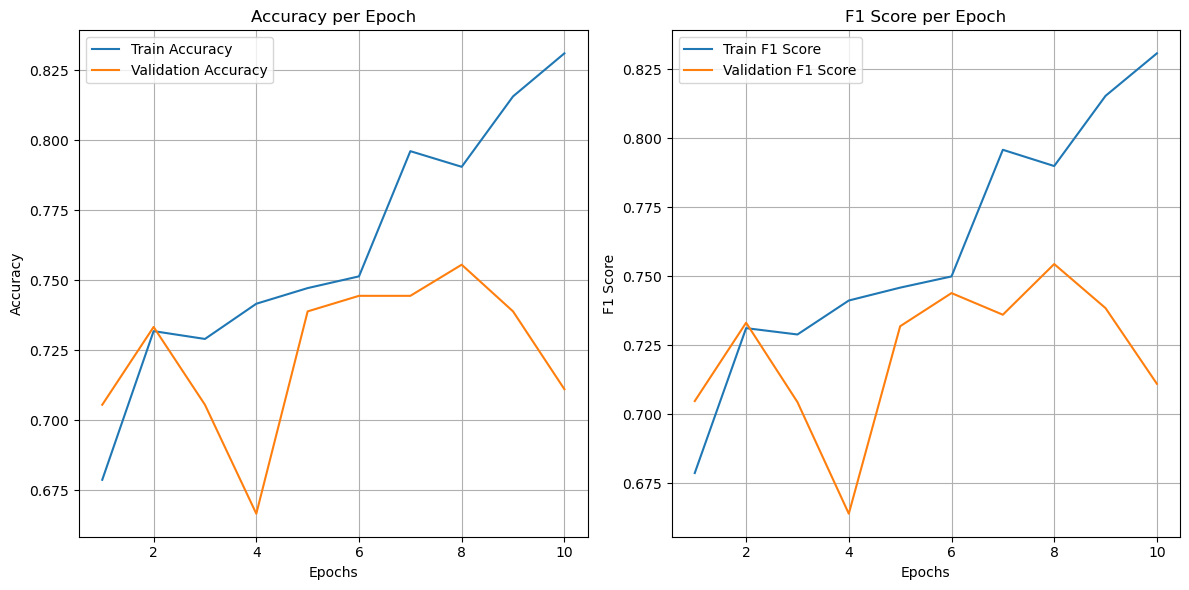

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Модель, критерий и оптимизатор
model = ResNet18WithSimpleFC(num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Обучение
num_epochs = 10
train_acc_history, val_acc_history, train_f1_history, val_f1_history = train_and_evaluate(
    model, dataloaders, criterion, optimizer, num_epochs, device=device
)

plot_metrics(train_acc_history, val_acc_history, train_f1_history, val_f1_history)

Тестирование модели:


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.03it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Точность на тестовом наборе: 0.7098
F1-мера: 0.7094


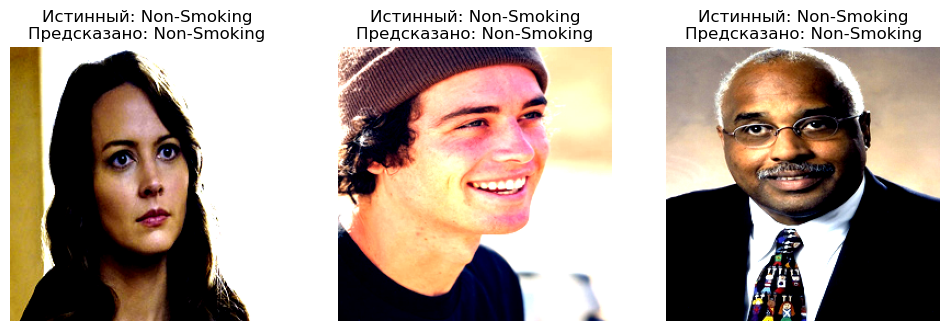

In [28]:
print("Тестирование модели:")
preds, labels, f1 = test_model(model, dataloaders['test'], device=device)

class_names = ["Non-Smoking", "Smoking"]
visualize_predictions(model, dataloaders['test'], class_names, device=device)

## Satelite Dataset

In [37]:
satellite_data_handler = SatelliteDataset(root_dir='data_2', img_size=(128, 128), batch_size=32)

satellite_train_loader = satellite_data_handler.train_loader
satellite_val_loader = satellite_data_handler.val_loader
satellite_test_loader = satellite_data_handler.test_loader

satellite_class_names = satellite_data_handler.dataset.classes
print(f"Классы: {satellite_class_names}")

Классы: ['cloudy', 'desert', 'green_area', 'water']


Эпоха 1/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:07<00:00, 16.13it/s]


train Loss: 0.3662 Acc: 0.8673 F1: 0.8673


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.03it/s]


val Loss: 0.1383 Acc: 0.9586 F1: 0.9585
Эпоха 2/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:07<00:00, 15.53it/s]


train Loss: 0.1990 Acc: 0.9315 F1: 0.9315


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.37it/s]


val Loss: 0.2329 Acc: 0.9266 F1: 0.9264
Эпоха 3/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:08<00:00, 15.31it/s]


train Loss: 0.1730 Acc: 0.9411 F1: 0.9411


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.38it/s]


val Loss: 0.3719 Acc: 0.8828 F1: 0.8790
Эпоха 4/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:07<00:00, 16.28it/s]


train Loss: 0.1660 Acc: 0.9437 F1: 0.9437


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 22.88it/s]


val Loss: 0.2658 Acc: 0.8722 F1: 0.8672
Эпоха 5/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:07<00:00, 16.00it/s]


train Loss: 0.1332 Acc: 0.9571 F1: 0.9571


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 22.13it/s]


val Loss: 0.7099 Acc: 0.8355 F1: 0.8215
Эпоха 6/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:07<00:00, 16.50it/s]


train Loss: 0.1181 Acc: 0.9624 F1: 0.9624


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 22.51it/s]


val Loss: 0.1150 Acc: 0.9562 F1: 0.9563
Эпоха 7/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:07<00:00, 16.40it/s]


train Loss: 0.1130 Acc: 0.9619 F1: 0.9620


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.93it/s]


val Loss: 1.4188 Acc: 0.8000 F1: 0.7699
Эпоха 8/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:08<00:00, 15.50it/s]


train Loss: 0.0958 Acc: 0.9655 F1: 0.9655


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.16it/s]


val Loss: 0.4774 Acc: 0.8935 F1: 0.8863
Эпоха 9/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:07<00:00, 15.54it/s]


train Loss: 0.1138 Acc: 0.9642 F1: 0.9642


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.95it/s]


val Loss: 0.5074 Acc: 0.8556 F1: 0.8496
Эпоха 10/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 124/124 [00:07<00:00, 16.07it/s]


train Loss: 0.0955 Acc: 0.9693 F1: 0.9693


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 21.81it/s]


val Loss: 0.3170 Acc: 0.8722 F1: 0.8665
Обучение завершено.
Лучшая F1: 0.9585


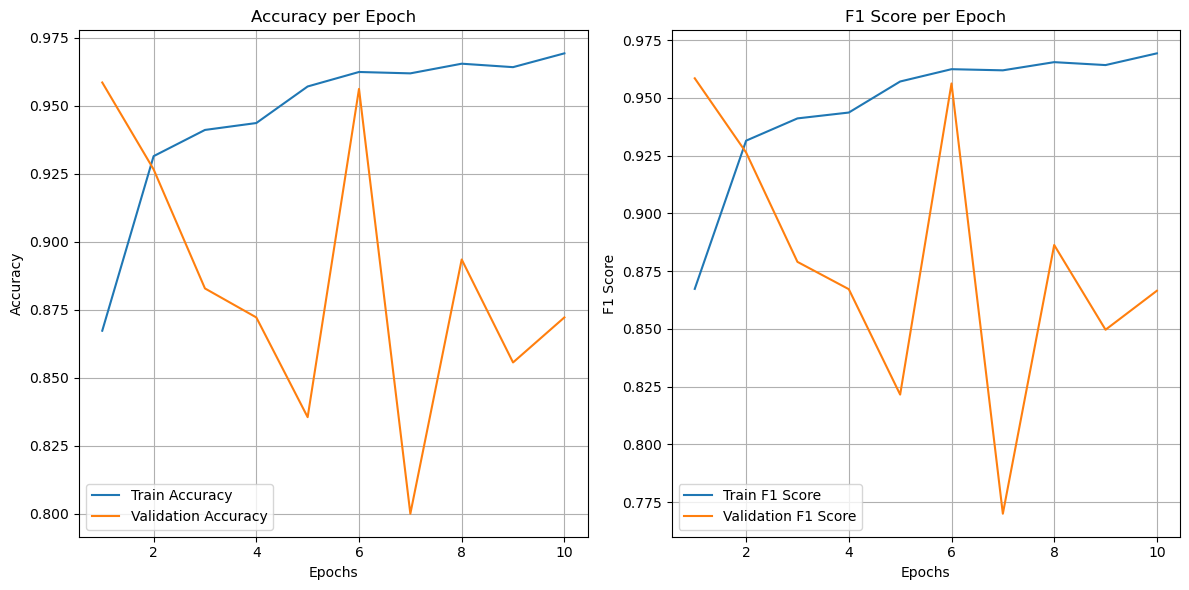

In [57]:
satellite_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Модель, критерий и оптимизатор
satellite_model = ResNet18WithSimpleFC(num_classes=len(satellite_class_names))  # num_classes = 4
satellite_model = satellite_model.to(satellite_device)
satellite_criterion = nn.CrossEntropyLoss()
satellite_optimizer = torch.optim.Adam(satellite_model.parameters(), lr=0.00005)

# Количество эпох
satellite_num_epochs = 10

# Обучение и оценка
satellite_train_acc_history, satellite_val_acc_history, satellite_train_f1_history, satellite_val_f1_history = train_and_evaluate(
    satellite_model, {"train": satellite_train_loader, "val": satellite_val_loader}, satellite_criterion, satellite_optimizer, satellite_num_epochs, device=satellite_device
)

plot_metrics(satellite_train_acc_history, satellite_val_acc_history, satellite_train_f1_history, satellite_val_f1_history)

Тестирование satellite модели:


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.64it/s]


Точность на тестовом наборе: 0.8675
F1-мера: 0.8609


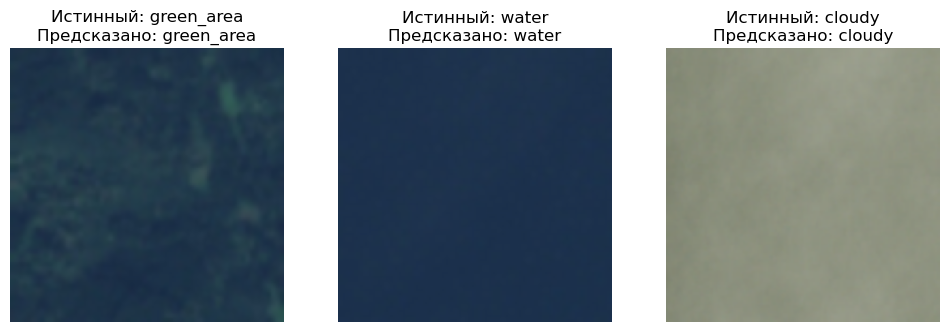

In [58]:
print("Тестирование satellite модели:")
satellite_preds, satellite_labels, satellite_f1 = test_model(satellite_model, satellite_test_loader, device=satellite_device)

visualize_predictions(satellite_model, satellite_test_loader, satellite_class_names, device=satellite_device)